In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
plt.rcParams.update({'font.size': 15})

from photochem import EvoAtmosphere
from photochem.clima import AdiabatClimate

from threadpoolctl import threadpool_limits
_ = threadpool_limits(limits=4)

# Problem: Simulate TRAPPIST-1e's atmosphere

Let's assume that TRAPPIST-1e is inhabited by methane-producing microbes and has an atmosphere similar to the Archean Earth's (e.g., rich in N$_2$, CO$_2$ and some CH$_4$). Create climate and photochemical models of this scenario to answer the following questions:

1. What is the global average surface temperature for your assumed atmospheric composition?
2. What is the surface CH$_4$ flux required to sustain your perscribed surface CH$_4$ concentration, and how does it compare to the Modern Earth's biological flux ($\sim 10^{11}$ molecules/cm$^2$/s)?
3. What is the main destruction path for CH$_4$ in the atmosphere?
4. What is the hydrocarbon haze production rate in g/cm$^2$/s, and how does it compare to Titan's ($\sim 10^{-14}$ g/cm$^2$/s)?

# Directions

Follow these directions to answer the above questions

## Step 1: Simulate the climate

Use the code cells below to simulate TRAPPIST-1e's climate. Assume the planet has a large surface ocean, and choose some reasonable surface pressures for N$_2$, CO$_2$ and CH$_4$, that resemble the Archean Earth's atmosphere. Check out Fig. 5 in [this review paper](https://www.science.org/doi/10.1126/sciadv.aax1420) for plausible concentrations, or alternatively feel free to just choose values that interest you. However, if you choose a very wild atmosphere (e.g. pure CH$_4$), then the models will probably fail to converge.

In [2]:
# Imports extra utilities
import input_files
import utils

# Makes a reaction file
input_files.create_zahnle_HNOC()

# Gets stellar spectrum
input_files.create_TRAPPIST1e_stellar_flux()

In [3]:
# Initialize the climate model
c = AdiabatClimate(
    'input/species_climate.yaml',
    'input/settings_climate.yaml',
    'TRAPPIST1e_stellar_flux.txt'
)

In [4]:
P_N2 = 1 # INPUT A PRESSURE HERE IN BARS
P_CO2 = 0.1 # INPUT A PRESSURE HERE IN BARS
P_CH4 = 1000e-6 # INPUT A PRESSURE HERE IN BARS

# Input atmospheric composition
P_i = np.ones(len(c.species_names))*1e-10
P_i[c.species_names.index('H2O')] = 270 # This is 1 ocean in bars
P_i[c.species_names.index('N2')] = P_N2
P_i[c.species_names.index('CO2')] = P_CO2
P_i[c.species_names.index('CH4')] = P_CH4
P_i *= 1e6 # convert to dynes/cm^2

# Several settings
c.RH = np.ones(len(c.species_names))*0.5 # 0.5 relative humidity
c.P_top = 1e-5*1e6
c.max_rc_iters = 30
# This is a convective adjustment parameter that should be about 0.05
c.convective_newton_step_size = 0.05

# Make guess for temperature structure with simple model
c.solve_for_T_trop = True
c.T_trop = c.rad.skin_temperature(0.3)
c.surface_temperature(P_i, T_guess=300)

# Solve for full RCE
converged = c.RCE(P_i, c.T_surf, c.T, c.convecting_with_below)

> 1. What is the global average surface temperature for your assumed atmospheric composition?

In [5]:
print('Surface Temperature = %.1f K'%c.T_surf)

Surface Temperature = 302.4 K


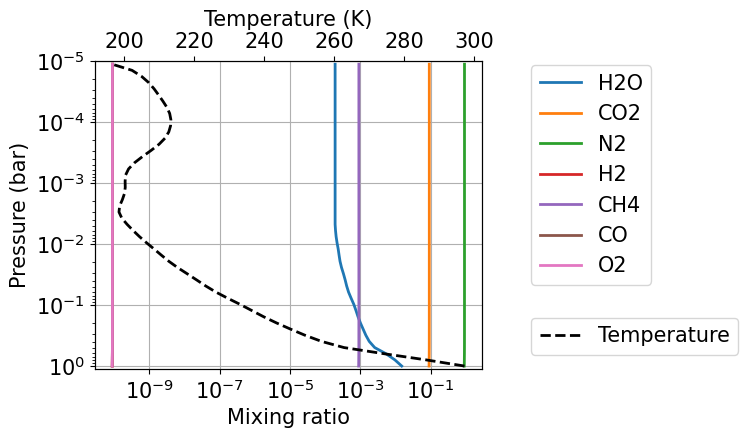

In [6]:
# Plot the atmosphere
fig, axs = utils.plot_atmosphere_clima(c)
plt.show()

Output the results of the climate model to a file. We will use them as initial conditions for the photochemical model. Also, choose an eddy diffusion coefficient for the photochemical simulation.

In [7]:
eddy = 1e5 # CHOOSE AN EDDY DIFFUSION HERE (cm^2/s)
c.out2atmosphere_txt('atmosphere_init.txt', eddy=np.ones(c.z.shape[0])*eddy, overwrite=True)

## Step 2: Simulate the photochemistry

Now simulate TRAPPIST-1e's photochemistry. The code below initializes the photochemical model, changes some settings, then sets surface pressure boundary conditions for N$_2$, CO$_2$ and CH$_4$ to values that you specified previously for climate modeling. Finally, the code cell moves the top of the atmosphere model domain to $10^{-7}$ bar, which is probably appropriate for a photochemical simulation.

After the code is initialized used the function `utils.find_steady_state` to compute a steady state. Then answer questions 2 - 4 from the beginning of the notebook. 

Hint: You will need to use the functions `pc.gas_fluxes`, `pc.production_and_loss` attached to the `EvoAtomsphere` object and also the function `haze_production_rate` in `utils.py`.

In [8]:
# Initialize the Photochemical code
pc = EvoAtmosphere(
    'zahnle_HNOC.yaml',
    'input/settings_photochemistry.yaml',
    'TRAPPIST1e_stellar_flux.txt',
    'atmosphere_init.txt'
)
pc.var.verbose = 0
pc.var.atol = 1e-23
pc.var.upwind_molec_diff = True

# Sets surface 
pc.set_lower_bc('N2',bc_type='press',press=P_N2*1e6)
pc.set_lower_bc('CO2',bc_type='press',press=P_CO2*1e6)
pc.set_lower_bc('CH4',bc_type='press',press=P_CH4*1e6)

# Need to move the TOA higher than the climate model
pc.update_vertical_grid(TOA_pressure=1e-7*1e6)

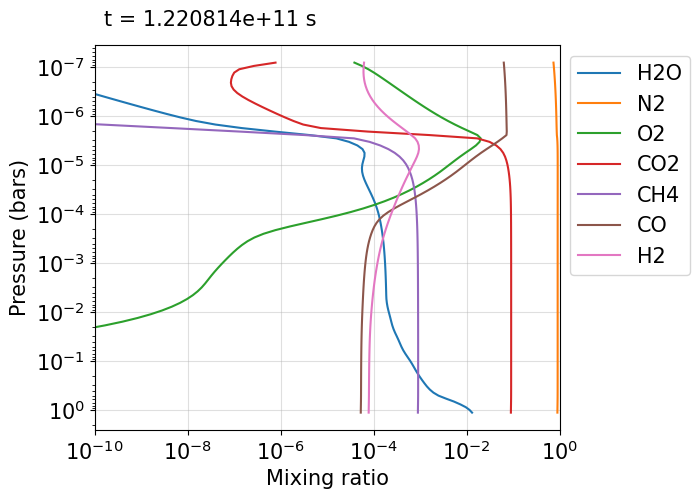

True

In [9]:
utils.find_steady_state(
    pc, 
    plot_species=['H2O','N2','O2','CO2','CH4','CO','H2'],
    xlim=(1e-10,1),
    plot_freq=50
)

> 2. What is the surface CH$_4$ flux required to sustain your perscribed surface CH$_4$ concentration, and how does it compare to the Modern Earth's biological flux ($\sim 10^{11}$ molecules/cm$^2$/s)?

In [10]:
fluxes = pc.gas_fluxes()[0]
print('%e'%fluxes['CH4'])

1.775229e+11


> 3. What is the main destruction path for CH$_4$ in the atmosphere?

In [11]:
pl = pc.production_and_loss('CH4',pc.wrk.usol)
for i in range(5):
    print('{:30}'.format(pl.loss_rx[i])+'%e'%pl.integrated_loss[i])

CH4 + O => CH3 + OH           1.258291e+11
CH4 + OH => CH3 + H2O         6.459704e+10
CH4 + hv => 1CH2 + H2         8.447565e+09
CH4 + hv => CH3 + H           6.803861e+09
CH4 + hv => CH2 + H + H       3.996104e+09


> 4. What is the hydrocarbon haze production rate in g/cm$^2$/s, and how does it compare to Titan's ($\sim 10^-{14}$ g/cm$^2$/s)?

In [12]:
haze_prod_rate = utils.haze_production_rate(pc)
print('%e'%haze_prod_rate)

7.564023e-23
